## *자전거 대여량 예측 >> "회귀" 문제*



# Data Description

* datetime - hourly date + timestamp
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter (계절) 
* holiday - whether the day is considered a holiday (휴일)
* workingday - whether the day is neither a weekend nor holiday (근무일)
* weather (날씨)
  * 1: Clear, Few clouds, Partly cloudy (맑음, 구름낌)
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (흐림)
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (약간의 눈비)
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (폭우, 강설 등)
* temp - temperature in Celsius (온도)
* atemp - "feels like" temperature in Celsius (체감온도)
* humidity - relative humidity (습도)
* windspeed - wind speed (풍속)
* casual - number of non-registered user rentals initiated (비등록사용자)
* registered - number of registered user rentals initiated (등록사용자)
* count - number of total rentals







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **0. 라이브러리, 데이터 로드**

In [2]:
# 라이브러리

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

warnings.filterwarnings("ignore")
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# 마이너스 수정
mpl.rc('axes', unicode_minus=False)

In [3]:
# parse_dates : 시간/날짜 형태 컬럼데이터를 datatime 형태로 변경하여 사용하기 위한 하이퍼파라미터
train = pd.read_csv("/content/train.csv", parse_dates=["datetime"]) 
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


# **1. EDA (Exploratory Data Analysis)**

In [4]:
train.shape

(10886, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
train.isnull().sum() # 데이터에 null값이 있는지 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
# 일시별 세부 확인을 위해 datetime을 날짜와 시간 분리하여 적재 > 컬럼 수 12개에서 18개로 증가
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape

(10886, 18)

In [8]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


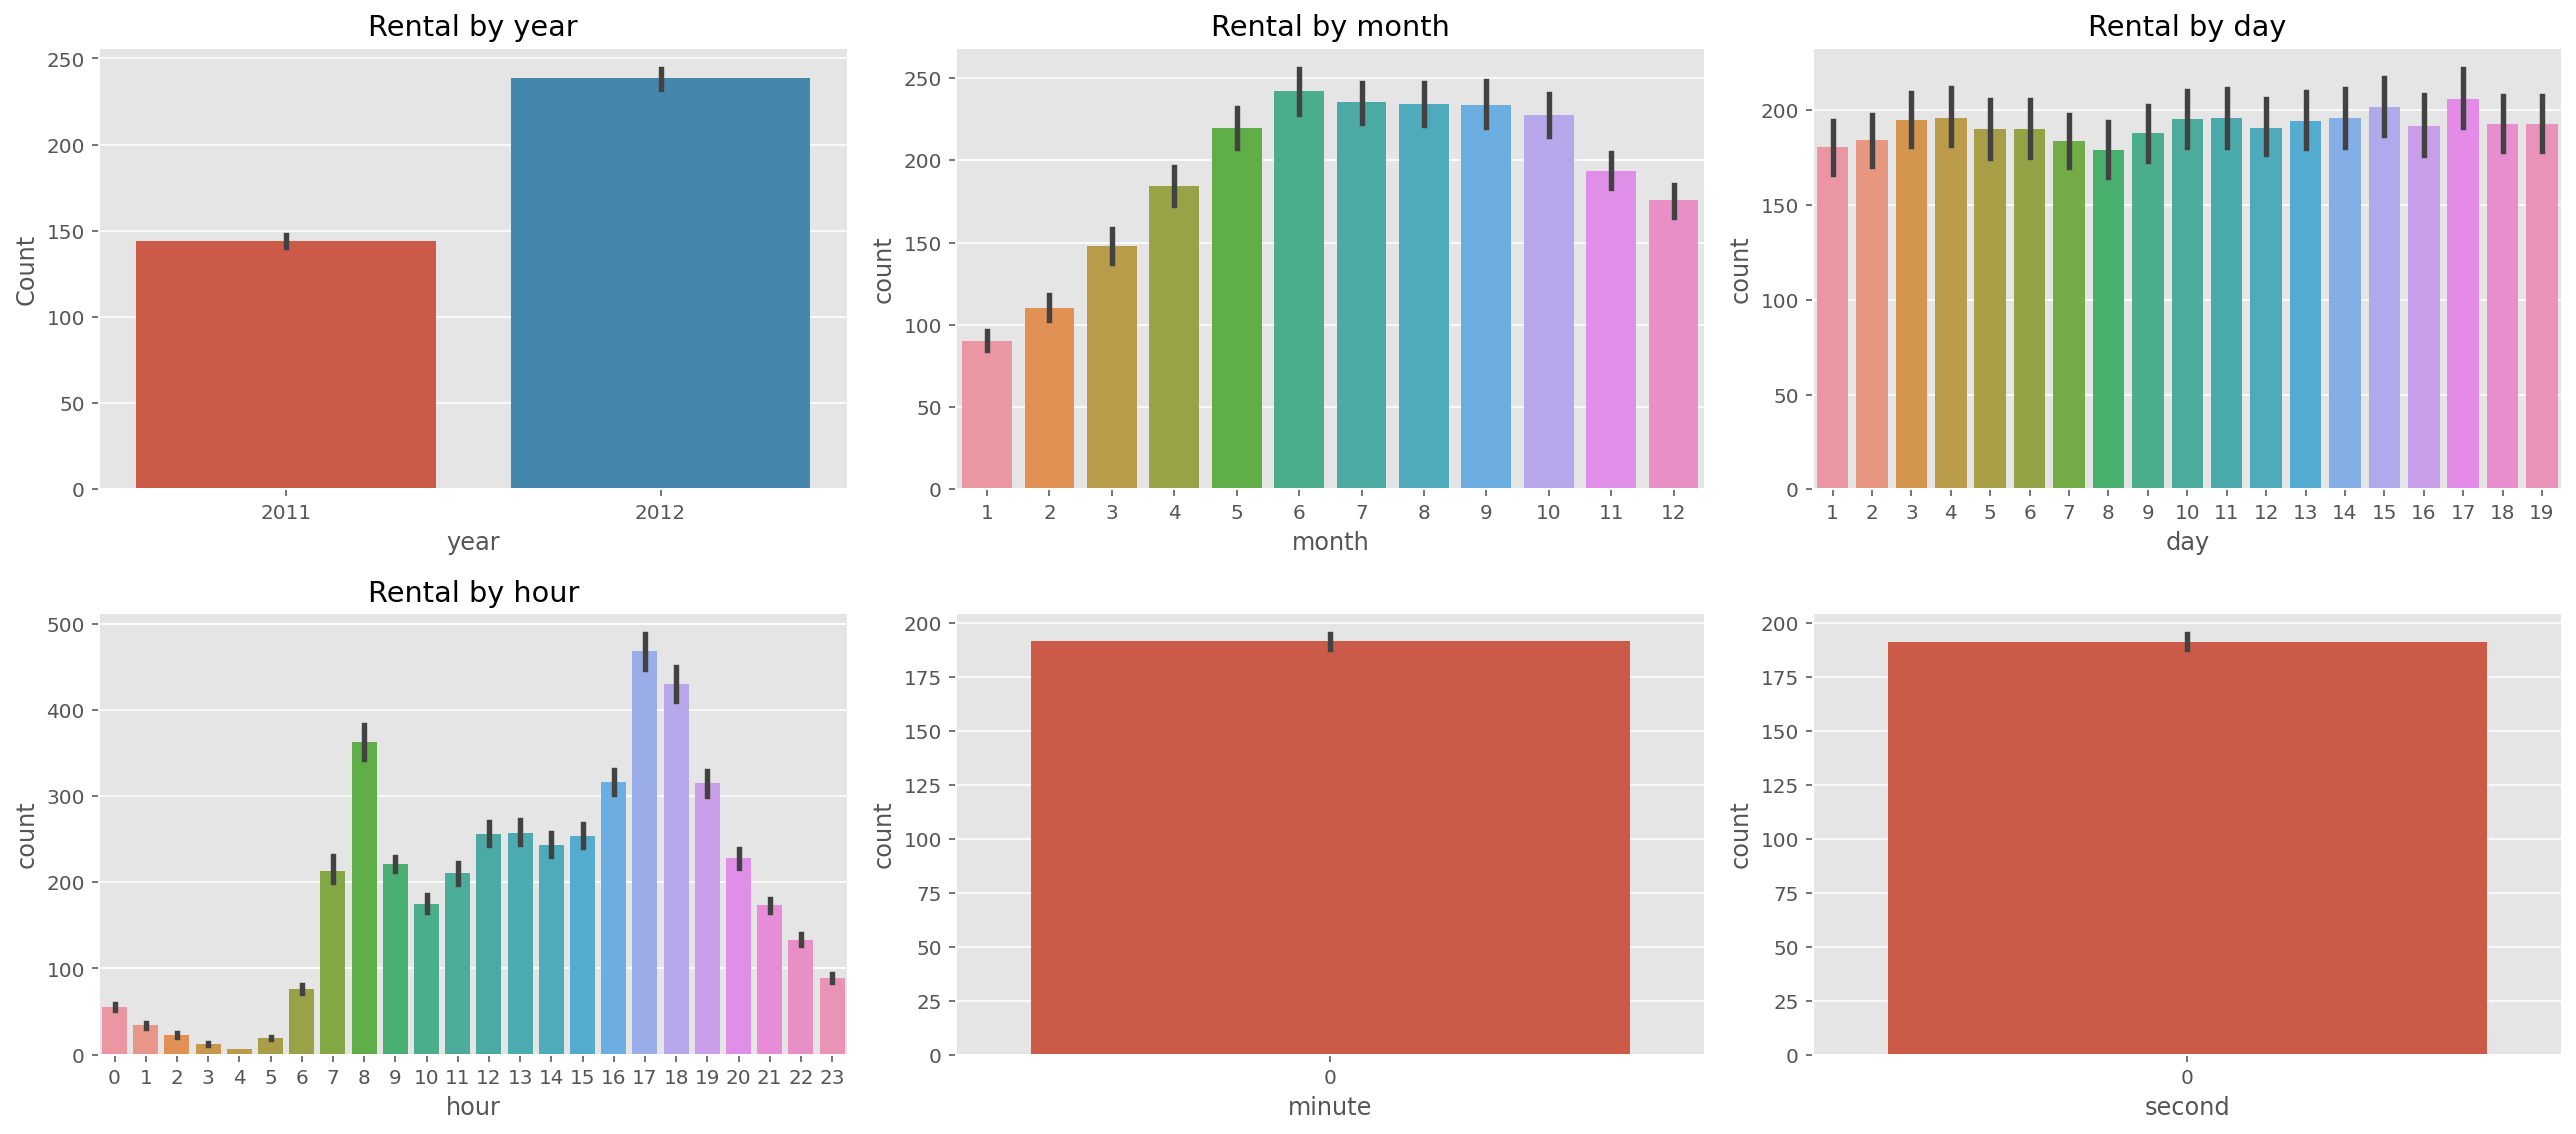

In [9]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)     # 1~19일까지만, 나머지는 test에 있음 > 피처 사용 x
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)  # 사용 못함
sns.barplot(data=train, x="second", y="count", ax=ax6)  # 사용 못함

ax1.set(ylabel='Count',title="Rental by year")
ax2.set(xlabel='month',title="Rental by month")
ax3.set(xlabel='day', title="Rental by day")
ax4.set(xlabel='hour', title="Rental by hour")

figure.tight_layout() # 그래프 겹치지 않게

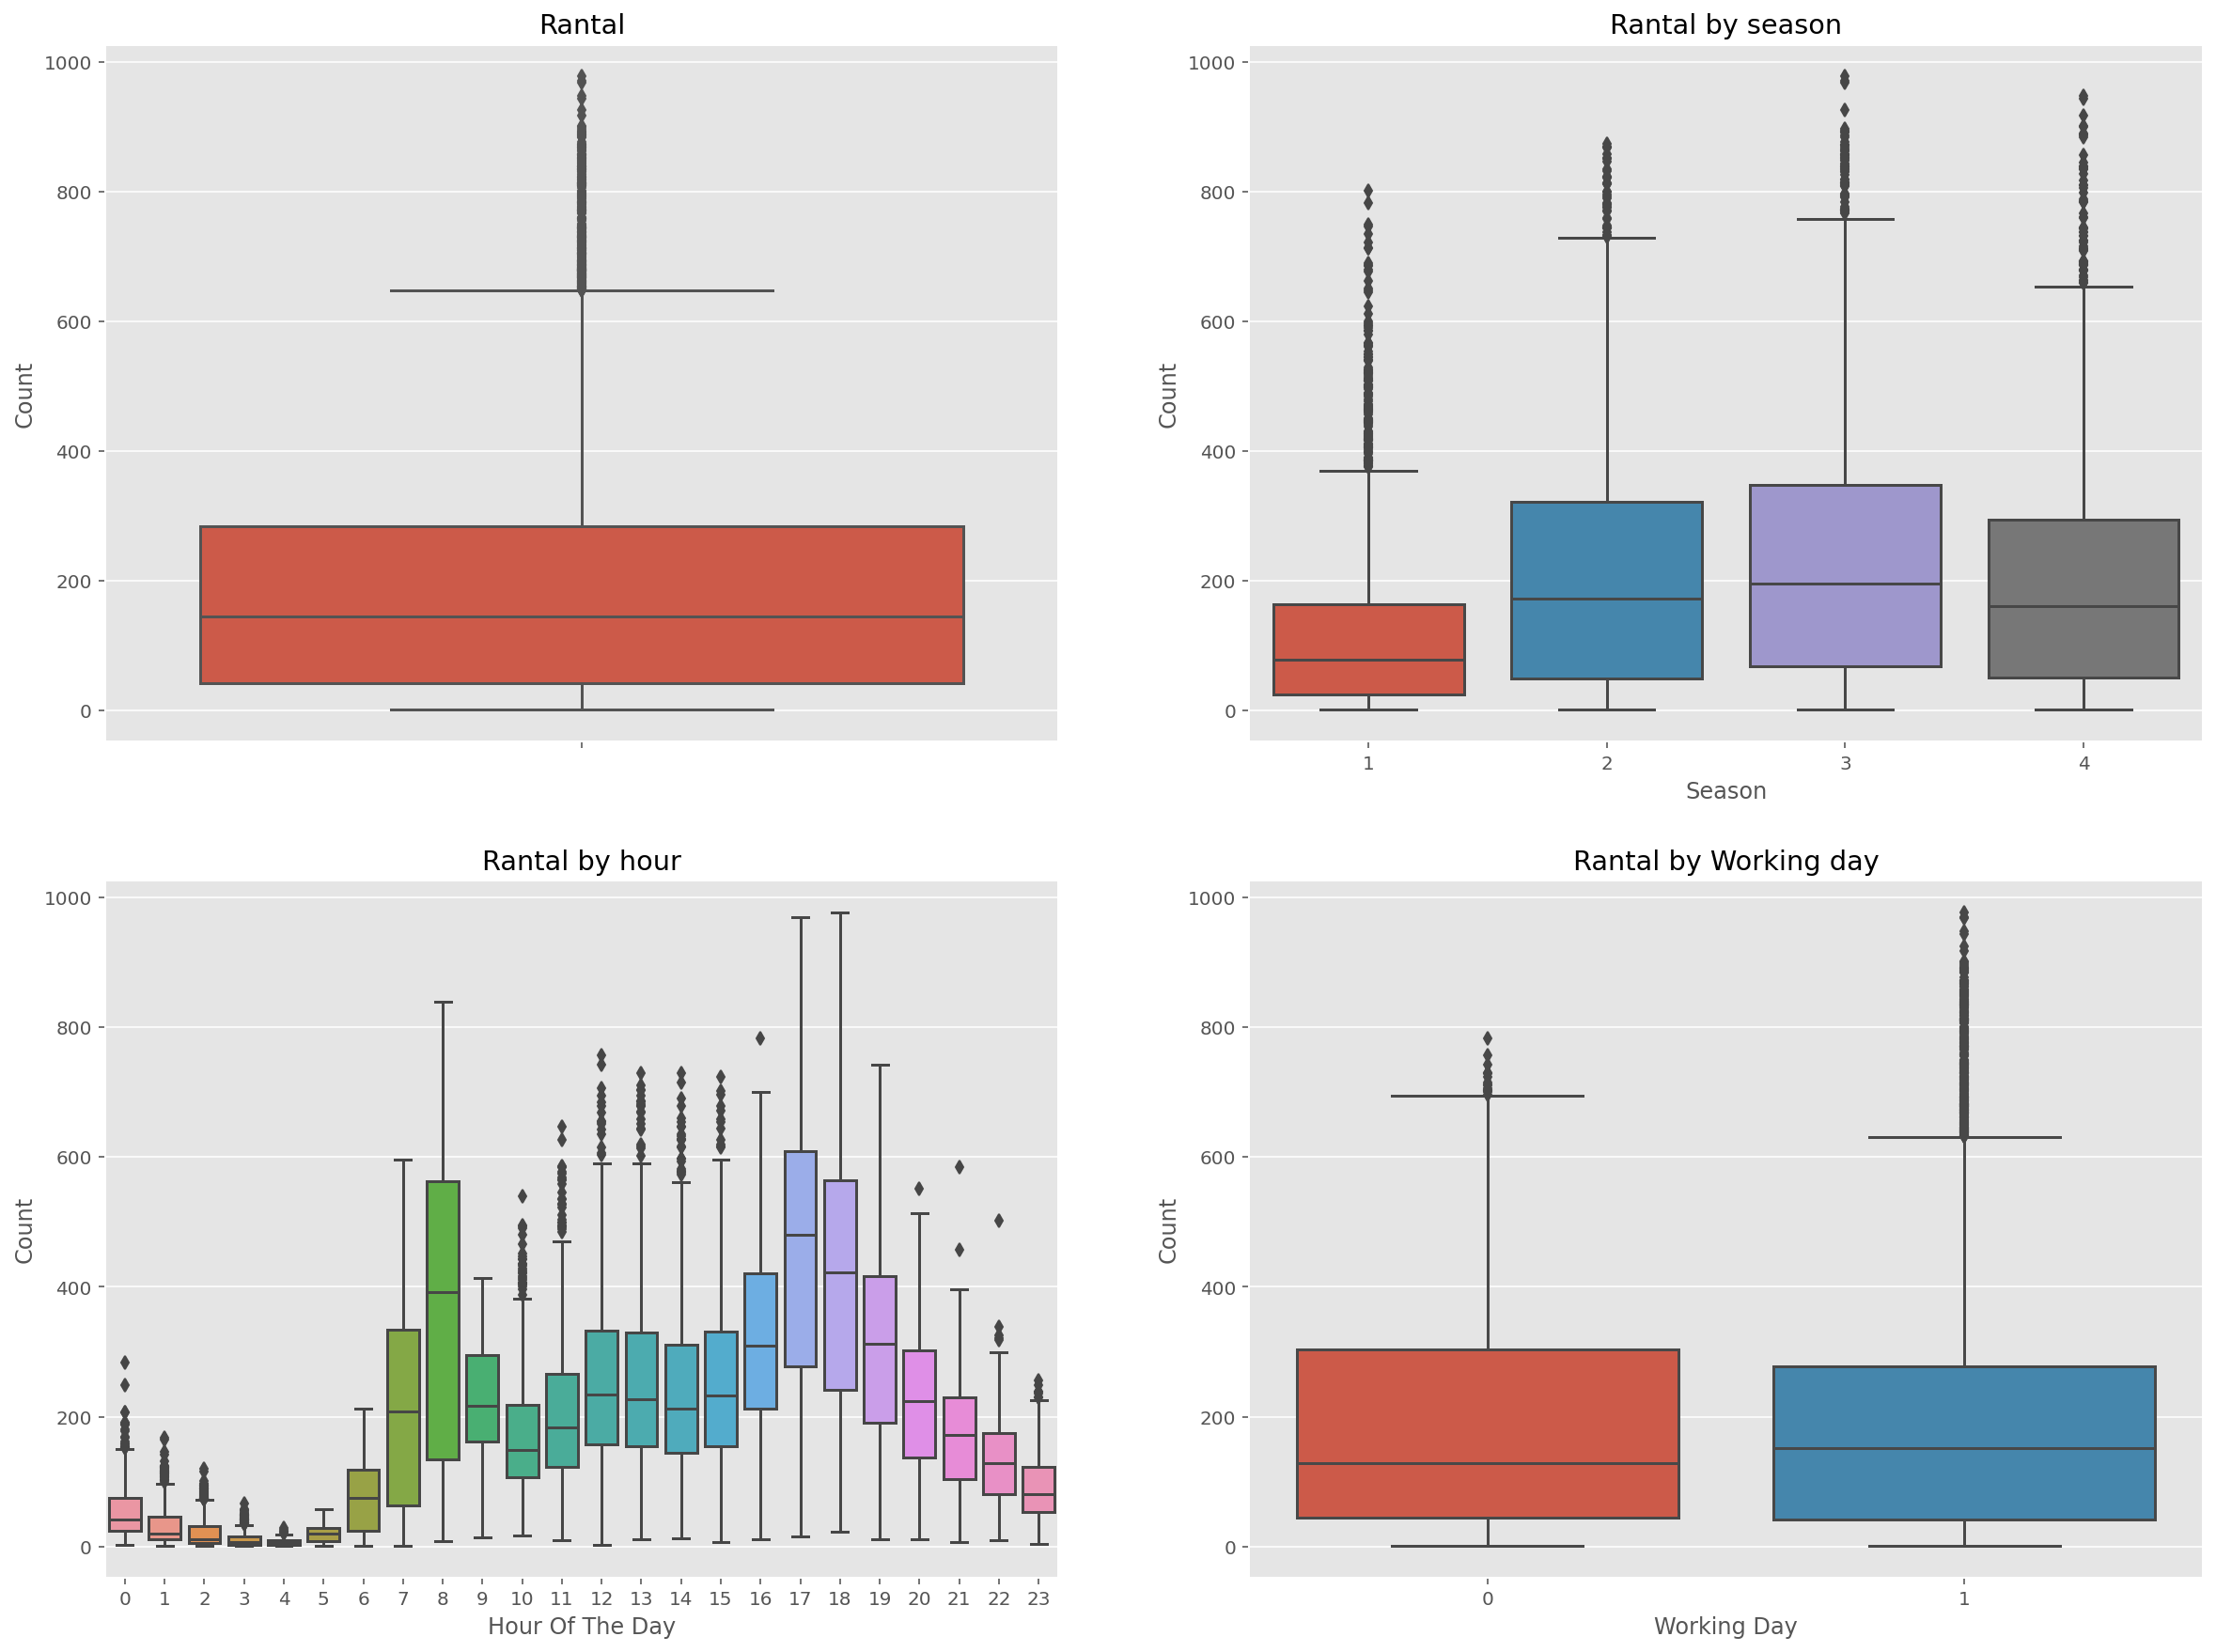

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 15)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Rantal")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Rantal by season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Rantal by hour")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Rantal by Working day")

figure.tight_layout()

In [11]:
# 요일 변수 추가 > 컬럼 18개에서 1개 추가된 19개
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [12]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

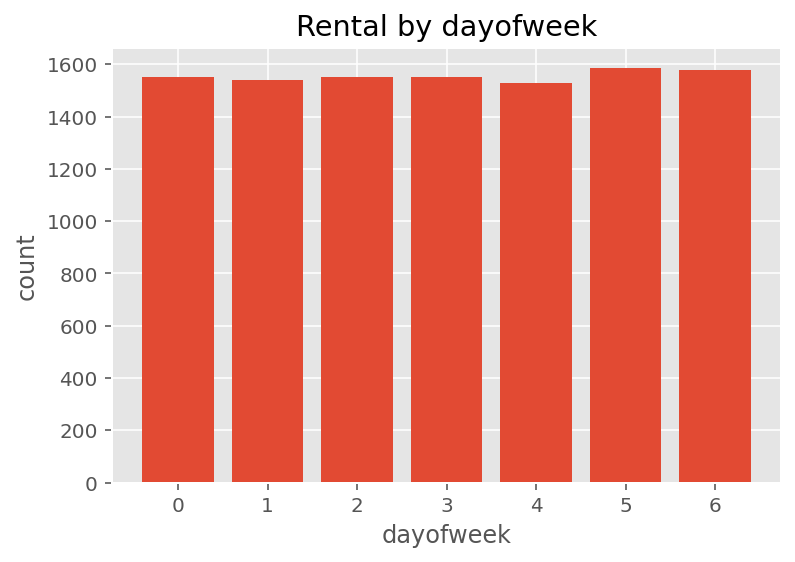

In [ ]:
plt.figure()

plt.title("Rental by dayofweek")

plt.xlabel("dayofweek")
plt.ylabel("count")

plt.bar([0,1,2,3,4,5,6], [1551,1539, 1551, 1553, 1529, 1584, 1579])
plt.show()

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


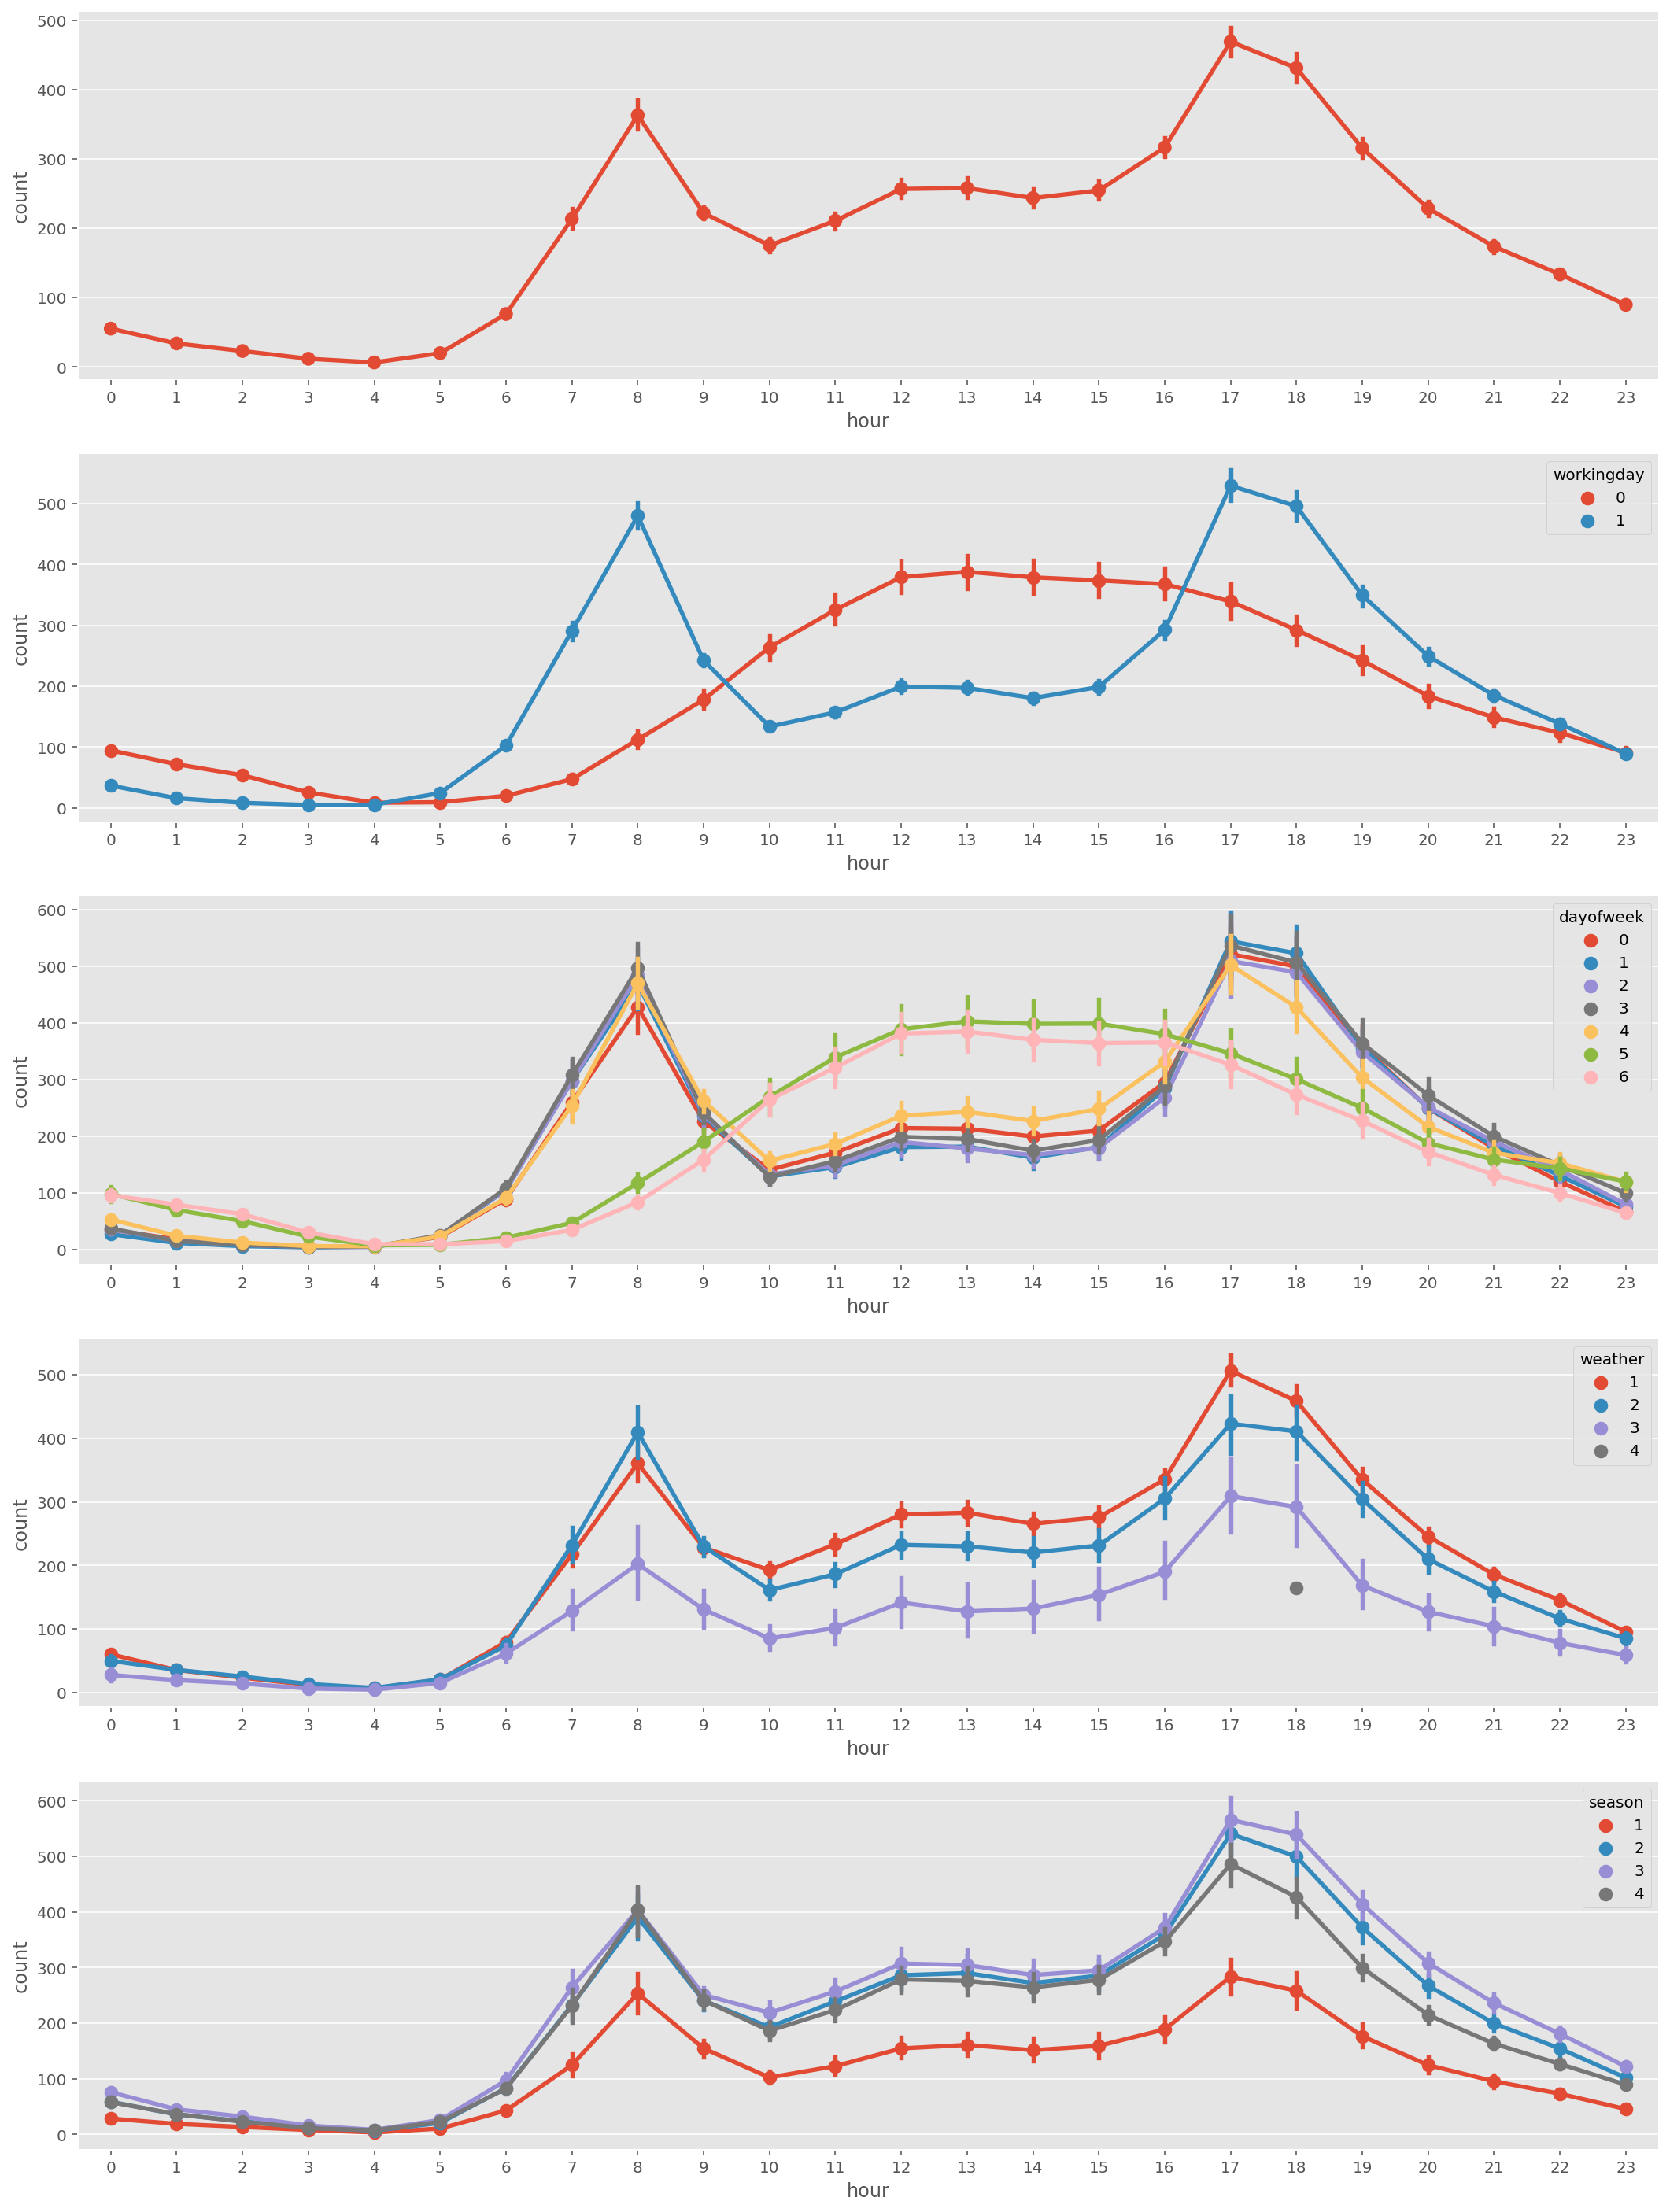

In [13]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [14]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


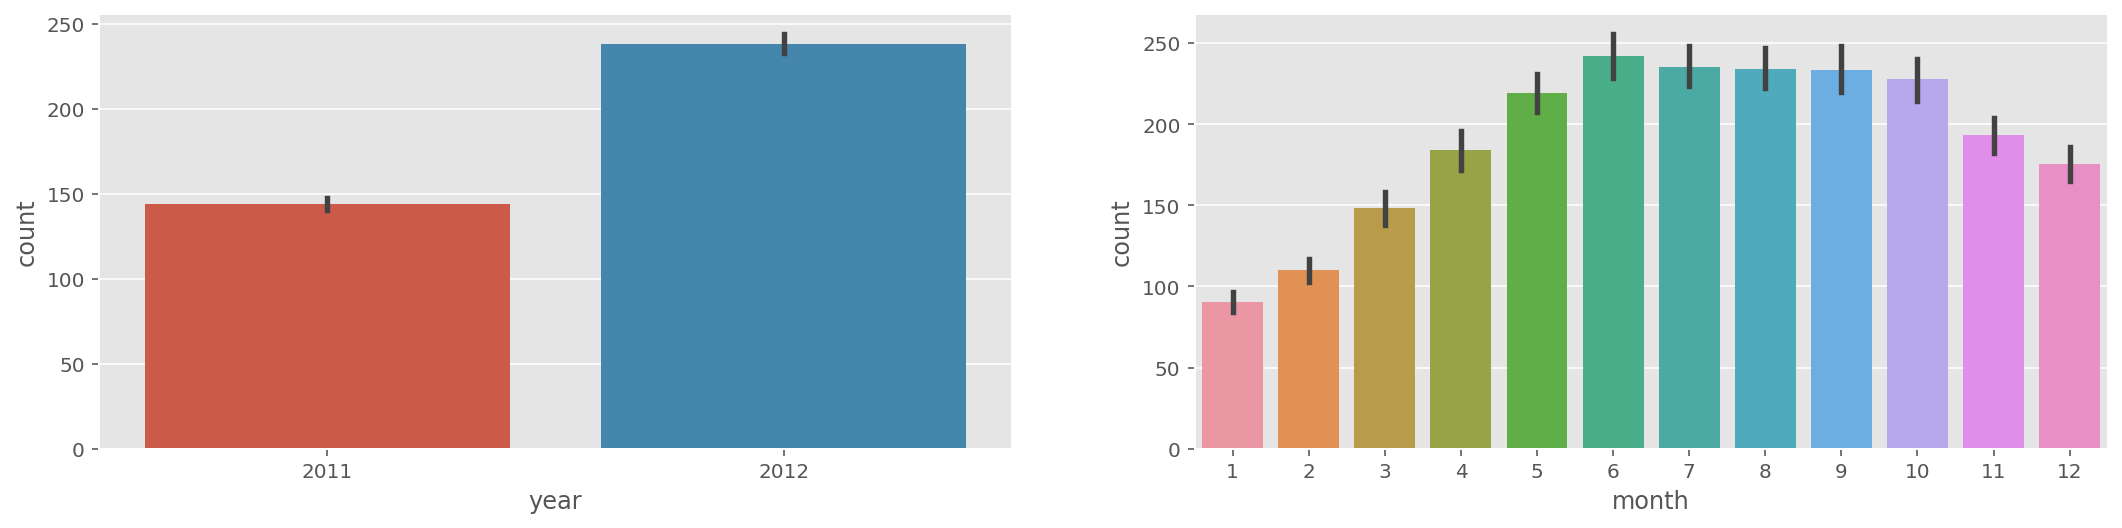

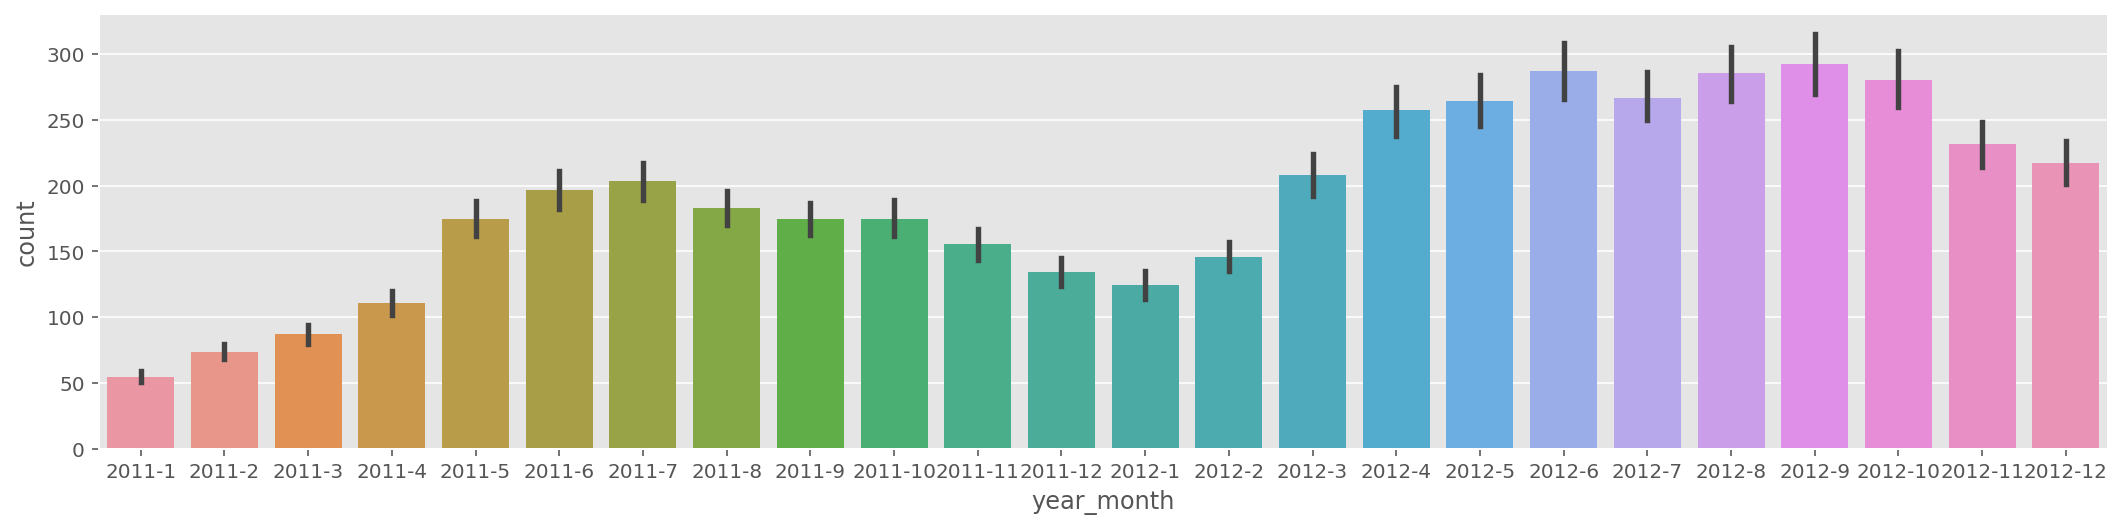

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

In [15]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

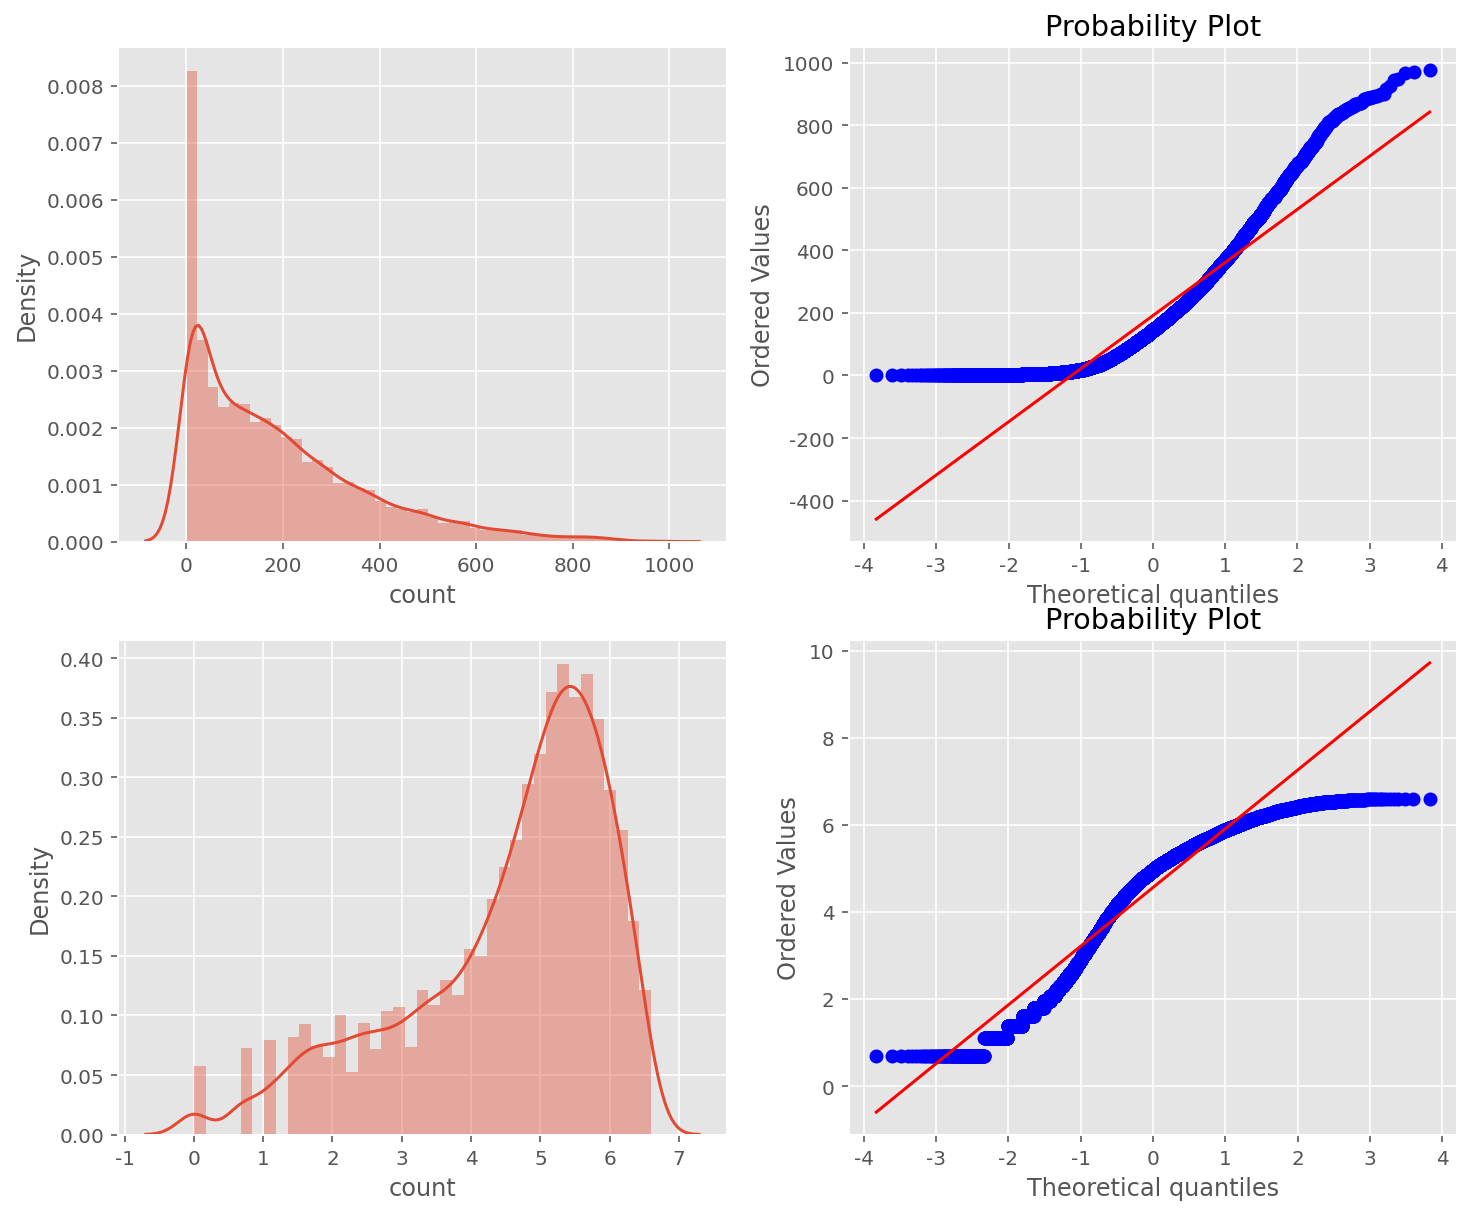

In [16]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

# **2. Feature Engineering**

In [17]:
train.shape

(10886, 20)

In [18]:
train.pop('year_month')

0         2011-1
1         2011-1
2         2011-1
3         2011-1
4         2011-1
          ...   
10881    2012-12
10882    2012-12
10883    2012-12
10884    2012-12
10885    2012-12
Name: year_month, Length: 10886, dtype: object

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [ ]:
train.shape

(10886, 19)

In [19]:
# parse_dates : 시간/날짜 형태 컬럼데이터를 datatime 형태로 변경하여 사용하기 위한 하이퍼파라미터
test = pd.read_csv("/content/test.csv", parse_dates=["datetime"]) 
test


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [20]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek

test.shape

(6493, 16)

In [42]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [21]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [22]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [23]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [24]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [25]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [26]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [47]:
y_train

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

# **3. 모델링**


* 평가지표 : RMSE 
  *  회귀모형 평가지표로 많이 사용
  *  MSE에 Root 씌운 것

> 


In [27]:
# from sklearn.ensemble import RandomForestRegressor
# rf_model = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=12)
# rf_model

# rf_model.fit(X_train, y_train)

# # 예측
# fr_pred = rf_model.predict(X_test)
# fr_pred

array([ 30.66887341,  13.76929363,   7.62569465, ..., 133.33768553,
       105.25469642,  92.60231033])

[Text(0.5, 1.0, 'test')]

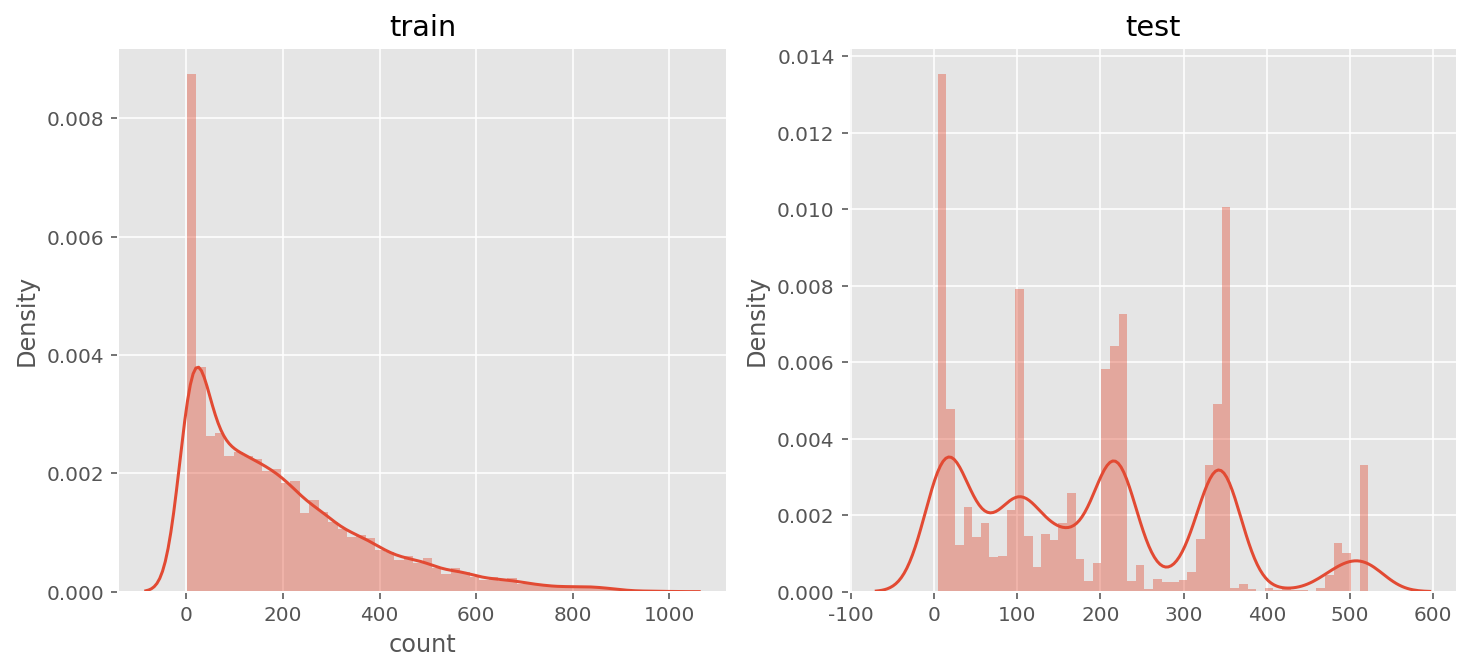

In [ ]:
# fig,(ax1,ax2) = plt.subplots(ncols=2)
# fig.set_size_inches(12,5)

# sns.distplot(y_train, ax=ax1, bins=50)
# ax1.set(title="train")

# sns.distplot(fr_pred, ax=ax2, bins=50)
# ax2.set(title="test")


In [28]:
# # 그라디언트 부스트

# from sklearn.ensemble import GradientBoostingRegressor

# gbm = GradientBoostingRegressor(n_estimators=1000, alpha=0.01, random_state=12);
# gbm.fit(X_train, y_train)

# #예측
# gbm_preds = gbm.predict(X_test)
# gbm_preds

array([  8.66742518,  -0.88424662,  -5.60383505, ..., 121.43491781,
        76.03551284,  41.48995804])

[Text(0.5, 1.0, 'test')]

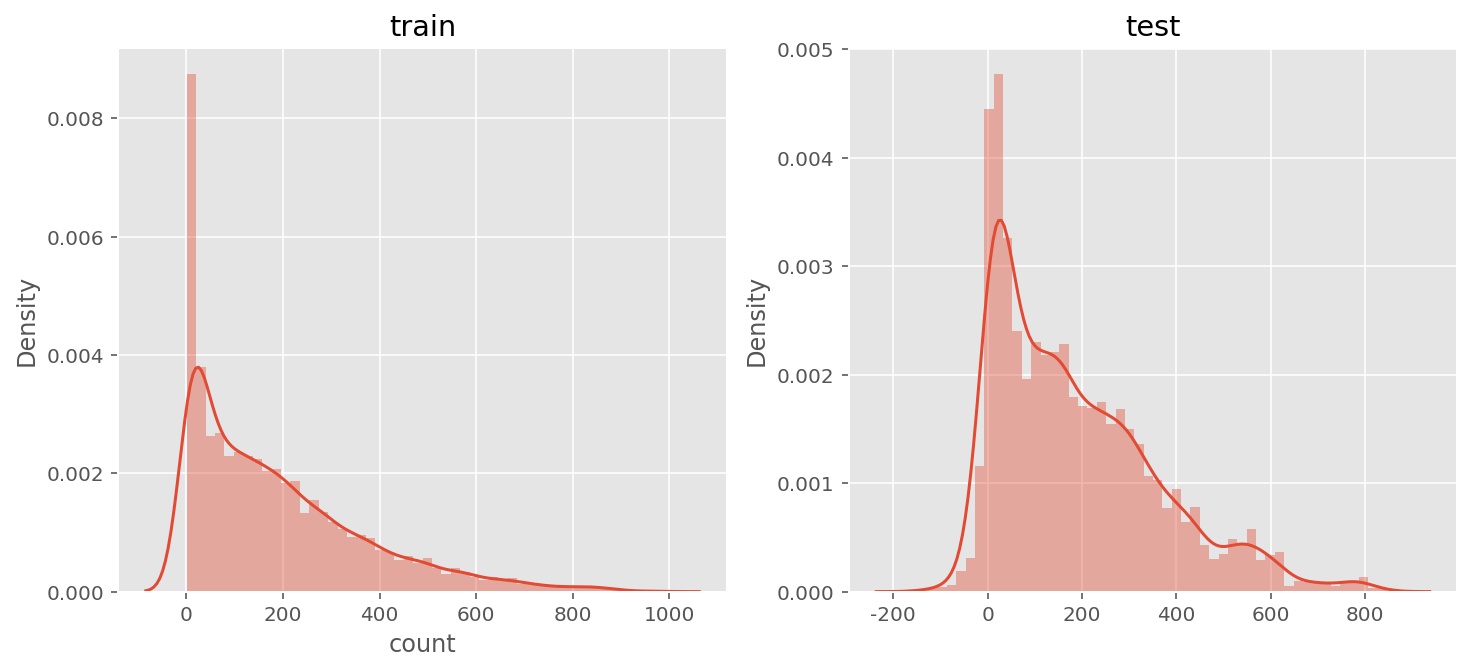

In [ ]:
# fig,(ax1,ax2) = plt.subplots(ncols=2)
# fig.set_size_inches(12,5)

# sns.distplot(y_train, ax=ax1, bins=50)
# ax1.set(title="train")

# sns.distplot(gbm_preds, ax=ax2, bins=50)
# ax2.set(title="test")

In [51]:
# 평가지표 > Rmsle

from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

In [52]:
# 랜덤포레스트

from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.1068236541406911


In [53]:
# 그라디언트 부스트

from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21357403727840335


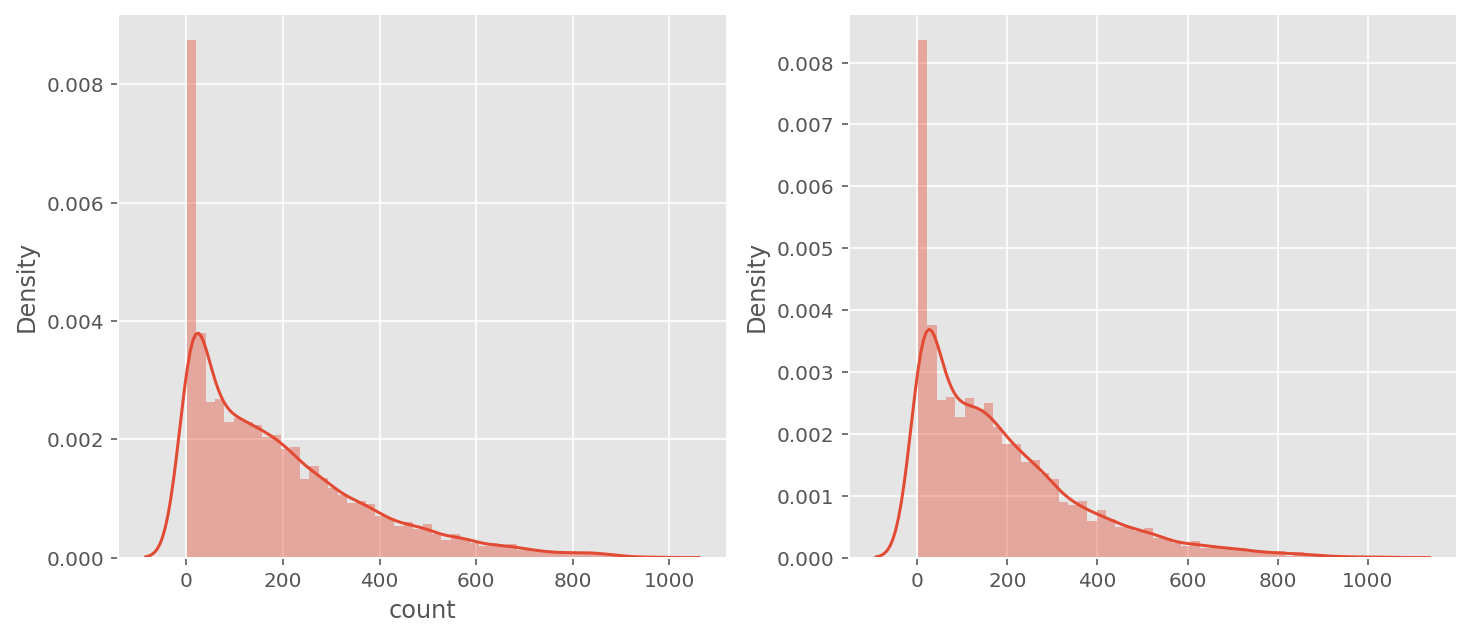

In [54]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)